**Importing libraries**

In [30]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.optimize import curve_fit
from lmfit.models import LinearModel
import linmix 
import time
from astropy.stats import poisson_conf_interval

**Capturing name of the PC**

In [31]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [32]:
#setting dots per inch for images
dpi = 150

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if PC_name_str == 'science12':
    cores = 30        
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

science12
30


**Defining constants**

In [33]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [34]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [35]:
%%time
z = 0.42372720
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
df_gal.describe()


CPU times: user 123 ms, sys: 12.5 ms, total: 135 ms
Wall time: 134 ms


,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],m_gas[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,93097.000000,93097.000000,93097.000000,9.309700e+04,9.309700e+04,93097.000000,93097.000000,93097.000000
mean,325576.133087,322500.028738,320613.762863,3.993206e+11,1.326202e+12,0.763965,0.349477,-0.509183
std,184863.273960,182799.587421,183249.915097,3.995129e+11,2.955465e+12,351.345586,343.572230,328.125457
min,1.864417,10.164207,0.260974,1.800010e+11,0.000000e+00,-2896.388700,-2323.086700,-2275.444800
25%,163866.950000,166201.380000,162514.560000,2.161480e+11,2.976010e+11,-219.363920,-215.157970,-201.740720
50%,332449.620000,329260.160000,319925.780000,2.784900e+11,5.810010e+11,-2.822351,2.646382,-3.028148
75%,483949.000000,475466.120000,478698.410000,4.192930e+11,1.244070e+12,216.770710,214.257250,200.506210
max,639996.190000,639980.940000,639993.120000,1.077460e+13,1.420090e+14,2423.330800,3048.129900,2638.449000


**Reading clusters dataset**

In [36]:
df_clusters_orig = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

df_clusters_orig.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6080.000000,6080.000000,6080.000000,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,326416.401838,322055.402286,321308.240244,6.356245e+13,2.109102,-1.647297,-4.296055
std,186021.550694,182650.899538,183665.854310,4.851698e+13,316.064539,306.226537,286.454388
min,19.163288,152.653880,87.370949,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,160978.575000,164793.430000,161863.925000,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,338884.565000,333274.345000,322110.075000,4.801630e+13,-3.619450,1.969450,-8.055475
75%,486227.747500,473556.765000,478893.610000,6.945502e+13,206.816750,207.755750,181.532000
max,639887.560000,639933.380000,639848.380000,7.438200e+14,1197.640000,1164.960000,1201.260000


**Removing clusters at edges of the simulation box**

In [37]:
def edge_clus_remover(clus_cube_size):
    
    low_bound = clus_cube_size//2
    upp_bound = 640000 - (clus_cube_size//2)
    
    df_clusters = df_clusters_orig[(df_clusters_orig['x[kpc/h]'] > low_bound) & 
                                   (df_clusters_orig['x[kpc/h]'] < upp_bound) & 
                                   (df_clusters_orig['y[kpc/h]'] > low_bound) & 
                                   (df_clusters_orig['y[kpc/h]'] < upp_bound) & 
                                   (df_clusters_orig['z[kpc/h]'] > low_bound) & 
                                   (df_clusters_orig['z[kpc/h]'] < upp_bound)]
    
    return df_clusters

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [38]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.5938062370014


2.380620866668027

**Calculating mean density of the simulation box for Eq. 1**

In [39]:
def delta_gal_mean_func(cell_size):
    
    df_gal_mean = df_gal.copy()

    df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / cell_size
    df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / cell_size
    df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / cell_size

    #making tuples, converting tuples to cell coordinates
    df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((640000//cell_size, 640000//cell_size, 640000//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_mean["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1

    delta_gal_mean = np.mean(gals_in_cell)
    
    return delta_gal_mean

In [40]:
gals_in_cell = np.random.randint(low = 0, high = 5, size = (2,2))
gals_in_cell = np.arange(10)
print(gals_in_cell)

def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

print(gehrels_confidence_limits(gals_in_cell))

[0 1 2 3 4 5 6 7 8 9]
(array([1.82578875, 2.28728978, 2.6273576 , 2.90886488, 3.15430001,
       3.37469012, 3.5763965 , 3.76347845, 3.93871192, 4.10409365]), array([0.        , 0.82853224, 1.28797565, 1.62766243, 1.90903635,
       2.15440975, 2.37476633, 2.57645249, 2.76352132, 2.93874579]))


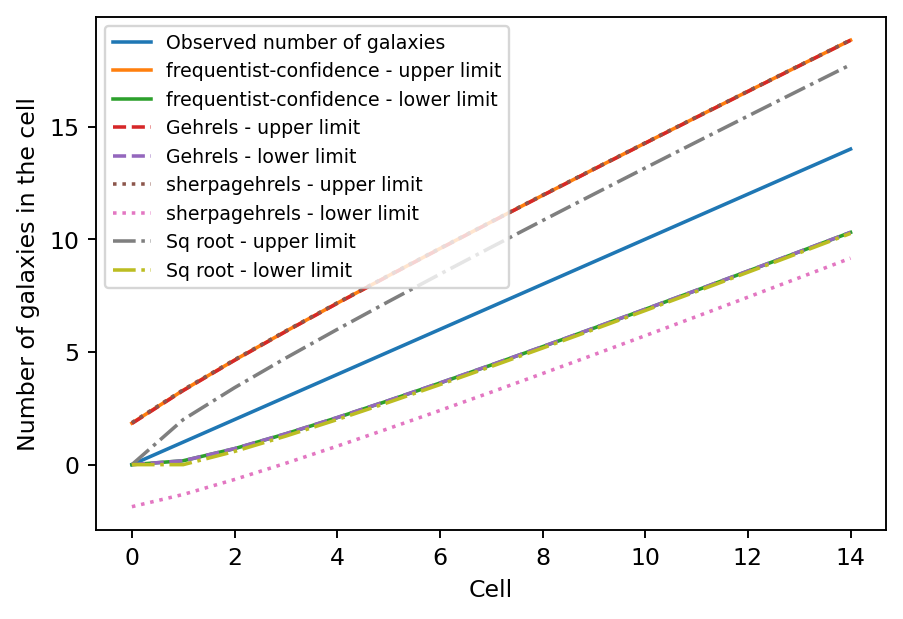

In [41]:
gals_in_cell = np.arange(15)

plt.figure(dpi = dpi + 20)

plt.plot(gals_in_cell, label = 'Observed number of galaxies')

plt.plot(poisson_conf_interval(gals_in_cell, interval='frequentist-confidence', sigma = 1)[1], label = 'frequentist-confidence - upper limit')
plt.plot(poisson_conf_interval(gals_in_cell, interval='frequentist-confidence')[0], label = 'frequentist-confidence - lower limit')

plt.plot(gals_in_cell + gehrels_confidence_limits(gals_in_cell)[0], label = 'Gehrels - upper limit', ls = 'dashed')
plt.plot(gals_in_cell - gehrels_confidence_limits(gals_in_cell)[1], label = 'Gehrels - lower limit', ls = 'dashed')

plt.plot(poisson_conf_interval(gals_in_cell, interval='sherpagehrels')[1], label = 'sherpagehrels - upper limit', ls = 'dotted')
plt.plot(poisson_conf_interval(gals_in_cell, interval='sherpagehrels')[0], label = 'sherpagehrels - lower limit', ls = 'dotted')

plt.plot(gals_in_cell + np.sqrt(gals_in_cell), label = 'Sq root - upper limit', ls = 'dashdot')
plt.plot(gals_in_cell - np.sqrt(gals_in_cell), label = 'Sq root - lower limit', ls = 'dashdot')

plt.legend(fontsize = 8)

plt.xlabel('Cell')
plt.ylabel('Number of galaxies in the cell');

In [42]:
np.random.seed(0)
dist = np.random.randint(10, size = (2,2,2))
print(dist)
dist_2 = np.random.randint(10, size = (2,2,2))
print(dist_2)
mean_array = np.mean([dist, dist_2], axis=0 )
print(mean_array)

[[[5 0]
  [3 3]]

 [[7 9]
  [3 5]]]
[[[2 4]
  [7 6]]

 [[8 8]
  [1 6]]]
[[[3.5 2. ]
  [5.  4.5]]

 [[7.5 8.5]
  [2.  5.5]]]


In [43]:
np.random.seed(0)
dist = np.random.randint(10, size = (2,2,2))
print(dist)
array = gehrels_confidence_limits(dist)
print(array)
print(np.mean(array, axis = 0))

[[[5 0]
  [3 3]]

 [[7 9]
  [3 5]]]
(array([[[3.37469012, 1.82578875],
        [2.90886488, 2.90886488]],

       [[3.76347845, 4.10409365],
        [2.90886488, 3.37469012]]]), array([[[2.15440975, 0.        ],
        [1.62766243, 1.62766243]],

       [[2.57645249, 2.93874579],
        [1.62766243, 2.15440975]]]))
[[[2.76454993 0.91289438]
  [2.26826366 2.26826366]]

 [[3.16996547 3.52141972]
  [2.26826366 2.76454993]]]


**Calculating Overdensity field for Eq. 1**

In [56]:
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

def overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, clus_cube_size, error_type):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal[(df_gal['x[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                           (df_gal['x[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                           (df_gal['y[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                           (df_gal['y[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                           (df_gal['z[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                           (df_gal['z[kpc/h]'] < (clus_z + clus_cube_size//2))]
    
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x - clus_cube_size//2)
    df_gal_cube['y[kpc/h]'] -= (clus_y - clus_cube_size//2)
    df_gal_cube['z[kpc/h]'] -= (clus_z - clus_cube_size//2)

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] / cell_size
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] / cell_size
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] / cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/delta_gal_mean) - 1
    
    
#     if error_type == 'sq_root':
#         #Error in gals_in_cell
#         gals_in_cell_error = np.sqrt(gals_in_cell)
#         delta_gal_error = gals_in_cell_error/delta_gal_mean
    
#     if error_type == 'gehrels_up':
#         #Error in gals_in_cell
#         gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
#         delta_gal_error = gals_in_cell_up_err/delta_gal_mean
        
#         gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
#         gals_in_cell_avg_err = np.mean(np.array([gals_in_cell_up_err, gals_in_cell_low_err]), axis = 0)
        
#     if error_type == 'gehrels_low':
#         #Error in gals_in_cell
#         gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
#         delta_gal_error = gals_in_cell_low_err/delta_gal_mean  
        
#         gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
#         gals_in_cell_avg_err = np.mean(np.array([gals_in_cell_up_err, gals_in_cell_low_err]), axis = 0)
#         delta_gal_error = gals_in_cell_avg_err/delta_gal_mean  
        
#     gals_in_cell_low_err, gals_in_cell_up_err = poisson_conf_interval(gals_in_cell, interval='frequentist-confidence', sigma = 1)    
#     gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
#     gals_in_cell_avg_err = np.mean(np.array([gals_in_cell_up_err, gals_in_cell_low_err]), axis = 0)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    delta_gal_error = gals_in_cell_avg_err/delta_gal_mean  
    
    #smoothing the overdensity of galaxies
#     delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)
    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
                   
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [45]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


In [46]:
dist = np.random.randint(10, size = (4,4,4))
print(dist.size)
mask = dist < 5
print(mask)
dist = dist[dist < 5]
print(dist.size)
print(dist)

64
[[[ True  True False False]
  [False False  True False]
  [False False False  True]
  [False False False False]]

 [[ True  True  True  True]
  [False  True  True  True]
  [False  True  True  True]
  [ True False  True  True]]

 [[False False  True  True]
  [False  True  True False]
  [ True  True  True  True]
  [False False False False]]

 [[ True  True  True False]
  [False  True  True False]
  [False False  True False]
  [False  True  True  True]]]
34
[2 4 1 1 4 3 0 3 0 2 3 1 3 3 3 0 1 0 4 3 2 2 0 0 4 4 1 4 1 1 3 2 0 3]


**Calculating velocity of clusters according to Eq. 1**

In [47]:
def clus_velocity_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, vel_terms, sigma_in_pix, 
                       clus_cube_size, error_type):
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, delta_gal_mean, cell_size, sigma_in_pix, 
                                          clus_cube_size, error_type)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(h*1e3)) / denom
    
    vx_est_cube = pre_fac * np.sum(integrand_x) 
    
    dist = np.cbrt(denom)
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
#     vx_est_error = pre_fac * np.sum(integrand_x_error)
    
    integrand_x_up = dy_cubed * (delta_matter + delta_matter_error) * (numer_x/(h*1e3)) / denom #in units of Mpc
    vx_est_up = pre_fac * np.sum(integrand_x_up)
    
    integrand_x_low = dy_cubed * (delta_matter - delta_matter_error) * (numer_x/(h*1e3)) / denom #in units of Mpc
    vx_est_low = pre_fac * np.sum(integrand_x_low)
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(h*1e3)) / denom
    
    vy_est_cube = pre_fac * np.sum(integrand_y) 
    
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
#     vy_est_error = pre_fac * np.sum(integrand_y_error)
    
    integrand_y_up = dy_cubed * (delta_matter + delta_matter_error) * (numer_y/(h*1e3)) / denom #in units of Mpc
    vy_est_up = pre_fac * np.sum(integrand_y_up)
    
    integrand_y_low = dy_cubed * (delta_matter - delta_matter_error) * (numer_y/(h*1e3)) / denom #in units of Mpc
    vy_est_low = pre_fac * np.sum(integrand_y_low)
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc    
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(h*1e3)) / denom
    
    vz_est_cube = pre_fac * np.sum(integrand_z) 
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
#     vz_est_error = pre_fac * np.sum(integrand_z_error)
    
    integrand_z_up = dy_cubed * (delta_matter + delta_matter_error) * (numer_z/(h*1e3)) / denom #in units of Mpc
    vz_est_up = pre_fac * np.sum(integrand_z_up)
    
    integrand_z_low = dy_cubed * (delta_matter - delta_matter_error) * (numer_z/(h*1e3)) / denom #in units of Mpc
    vz_est_low = pre_fac * np.sum(integrand_z_low)
    
    return(vx_est, vy_est, vz_est, vx_est_up, vy_est_up, vz_est_up, vx_est_low, vy_est_low, vz_est_low, vx_est_error, vy_est_error, vz_est_error, vx_est_cube, vy_est_cube, vz_est_cube)


**Calculating sigma for smoothing**

In [48]:
def sigma_calc(cell_size):
    
    FWHM = 2000                           #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
    FWHM_in_pix = FWHM/cell_size          #in pixel units
    sigma_in_pix = FWHM_in_pix/(2.35482)  #in pixel units
    
    return sigma_in_pix

In [49]:
def lmfit_func(df_clusters_est_err, errors):
    model = LinearModel()

    result = model.fit(df_clusters_est_err['vx_est[km/s]'], x = df_clusters_est_err['vx[km/s]'], weights = 1/errors)

#     print(result.fit_report())
#     print(result.plot())
    
    return result.params['slope'].value, result.params['intercept'].value
    

In [50]:
def linmix_func(df_clusters_est_err, errors):
    t_i = time.time()

    lm = linmix.LinMix(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], ysig = errors)
    lm.run_mcmc(miniter = 100, maxiter = 1000, silent=True)

    print(time.time() - t_i)
    print(len(lm.chain))
    
    index_90 = int(len(lm.chain) * 0.9)
    
    return lm.chain['beta'][-index_90:].mean(), lm.chain['alpha'][-index_90:].mean()

**Plotting the scatter plots & histograms for assesment of velocity estimates**

In [51]:
def plotting_func_backup(df_clusters_est_err, cell_size, clus_cube_size_actual):
    
    fig = plt.figure(dpi = dpi, figsize = (10,12), facecolor=(1, 1, 1))

    point_size = 4
    cluster_jump = 50
    
    plt.subplot(3,2,1)
    plt.errorbar(df_clusters_est_err['vx[km/s]'][::cluster_jump], df_clusters_est_err['vx_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vx_est_up_err[km/s]'][::cluster_jump], fmt='.', ecolor='C6')
    plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
    low_lim, high_lim = -2000, 2000
    plt.gca().set_xticks(range(low_lim, high_lim+1, 1000))
    plt.gca().set_yticks(range(low_lim, high_lim, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(low_lim,high_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vx - scatter plot')
    
    x_pos_text = 0.40
    x_pos_text_hist = 0.65
    text_font_size = 7
    
    plt.text(x_pos_text, 0.15, f'Clusters: {len(df_clusters_est_err)} ({cluster_jump}th plotted)', transform=plt.gca().transAxes, fontsize = 0.75 * text_font_size)
     
    x_range = np.arange(low_lim, high_lim+1, 5)    
    def fit_func(x, m, c):
        return m*x + c
    
    param_x, cov_x = curve_fit(fit_func, df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], 
                           sigma = df_clusters_est_err['vx_est_up_err[km/s]'], absolute_sigma=True)
        
#     plt.text(x_pos_text, 0.09, f'Slope: {param_x[0].round(2)} $\pm$ {cov_x[0,0].round(2)}', transform=plt.gca().transAxes, fontsize = text_font_size)
#     plt.text(x_pos_text, 0.03, f'Zero point: {param_x[1].round(2)} $\pm$ {cov_x[1,1].round(2)} km/s', transform=plt.gca().transAxes, fontsize = text_font_size)
    
    plt.plot(x_range, fit_func(x_range, *param_x), label = 'Linear fit - scipy', c = 'C2')
    
    param_x_lmfit = lmfit_func(df_clusters_est_err)
    plt.plot(x_range, fit_func(x_range, *param_x_lmfit), label = 'Linear fit - lmfit', c = 'C3')
    
#     param_x_linmix = linmix_func(df_clusters_est_err)
    param_x_linmix = lm.chain['beta'][-500:].mean(), lm.chain['alpha'][-500:].mean()
    plt.plot(x_range, fit_func(x_range, *param_x_linmix), label = 'Linear fit - linmix', c = 'C4')    
    
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend(loc = 'upper left')
                                 
    plt.text(x_pos_text, 0.09, f'Slope: {param_x[0].round(2)} (scipy), {param_x_lmfit[0].round(2)} (lmfit), {param_x_linmix[0].round(2)} (linmix)', 
             transform=plt.gca().transAxes, fontsize = 0.75 * text_font_size)
    plt.text(x_pos_text, 0.03, f'Intercept: {param_x[1].round(2)}  (scipy), {param_x_lmfit[1].round(2)} (lmfit), {param_x_linmix[1].round(2)} (linmix)', 
             transform=plt.gca().transAxes, fontsize = 0.75 * text_font_size)
                                 
    
    plt.subplot(3,2,2)
    residuals_x = fit_func(df_clusters_est_err['vx[km/s]'], *param_x) - df_clusters_est_err['vx_est[km/s]']
    plt.hist(residuals_x, bins = 100)
    plt.xlabel('Residual: V$_{\mathrm{x, fit}}$ - V$_{\mathrm{x, est}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))
    y_low, y_high = plt.ylim()
    plt.ylim(y_low, y_high + 15)
    
    plt.text(0.02, 0.90, r'Mean (V$_{\mathrm{x, est}}$): ' + f"{round(np.mean(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.83, r'SD (V$_{\mathrm{x, est}}$): ' + f"{round(np.std(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.76, r'Mean (Error in V$_{\mathrm{x, est, up}}$): ' + f"{round(np.mean(df_clusters_est_err['vx_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.69, r'SD (Error in V$_{\mathrm{x, est, up}}$): ' + f"{round(np.std(df_clusters_est_err['vx_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    
    minus_one = {-1}
    plt.text(x_pos_text_hist, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(x_pos_text_hist, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    mean_x = np.mean(residuals_x)
    plt.text(x_pos_text_hist, 0.76, f"Mean (residual): {round(mean_x, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
#     SD_x = np.sqrt(np.mean((residuals_x)**2))
    SD_x = np.std(residuals_x)
    plt.text(x_pos_text_hist, 0.69, f"SD (residual): {round(SD_x, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    r_vx = np.corrcoef(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0]
    plt.text(x_pos_text_hist, 0.62, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes, fontsize = text_font_size)

    plt.title('Distribution of residuals in V$_{\mathrm{x, est}}$ fitting')




    plt.subplot(3,2,3)
    plt.errorbar(df_clusters_est_err['vy[km/s]'][::cluster_jump], df_clusters_est_err['vy_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vy_est_up_err[km/s]'][::cluster_jump], fmt='.', ecolor='C6')
    plt.xlabel('V$_\mathrm{y, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{y, estimated}$ (km/s)')
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vy - scatter plot')
    plt.text(x_pos_text, 0.15, f'Clusters: {len(df_clusters_est_err)} ({cluster_jump}th plotted)', transform=plt.gca().transAxes, fontsize = text_font_size)
    

    x_range = np.arange(low_lim, high_lim+1, 5)    
       
    param_y, cov_y = curve_fit(fit_func, df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'], 
                           sigma = df_clusters_est_err['vy_est_up_err[km/s]'], absolute_sigma=True)
    
    plt.text(x_pos_text, 0.09, f'Slope: {param_y[0].round(2)} $\pm$ {cov_y[0,0].round(2)}', transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(x_pos_text, 0.03, f'Zero point: {param_y[1].round(2)} $\pm$ {cov_y[1,1].round(2)} km/s', transform=plt.gca().transAxes, fontsize = text_font_size)
    
    plt.plot(x_range, fit_func(x_range, *param_y), label = 'Linear fit', c = 'C2')
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend(loc = 'upper left')

    plt.subplot(3,2,4)
    residuals_y = fit_func(df_clusters_est_err['vy[km/s]'], *param_y) - df_clusters_est_err['vy_est[km/s]']
    plt.hist(residuals_y, bins = 100)
    plt.xlabel('Residual: V$_{\mathrm{y, fit}}$ - V$_{\mathrm{y, est}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))
    y_low, y_high = plt.ylim()
    plt.ylim(y_low, y_high + 15)
    
    plt.text(0.02, 0.90, r'Mean (V$_{\mathrm{y, est}}$): ' + f"{round(np.mean(df_clusters_est_err['vy_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.83, r'SD (V$_{\mathrm{y, est}}$): ' + f"{round(np.std(df_clusters_est_err['vy_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.76, r'Mean (Error in V$_{\mathrm{y, est, up}}$): ' + f"{round(np.mean(df_clusters_est_err['vy_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.69, r'SD (Error in V$_{\mathrm{y, est, up}}$): ' + f"{round(np.std(df_clusters_est_err['vy_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    

    plt.text(x_pos_text_hist, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(x_pos_text_hist, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    mean_y = np.mean(residuals_y)
    plt.text(x_pos_text_hist, 0.76, f"Mean (residual): {round(mean_y, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
#     SD_y = np.sqrt(np.mean(residuals_y**2))
    SD_y = np.std(residuals_y)
    plt.text(x_pos_text_hist, 0.69, f"SD (residual): {round(SD_y, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    r_vy = np.corrcoef(df_clusters_est_err['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0]
    plt.text(x_pos_text_hist, 0.62, f'Pearson\'s r: {round(r_vy, 2)}', transform=plt.gca().transAxes, fontsize = text_font_size)

    plt.title('Distribution of residuals in V$_{\mathrm{y, est}}$ fitting')




    plt.subplot(3,2,5)
    plt.errorbar(df_clusters_est_err['vz[km/s]'][::cluster_jump], df_clusters_est_err['vz_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vz_est_up_err[km/s]'][::cluster_jump], fmt='.', ecolor='C6')
    plt.xlabel('V$_\mathrm{z, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{z, estimated}$ (km/s)');
    plt.gca().set_xticks(range(-2000, 2001, 1000))
    plt.gca().set_yticks(range(-2000, 2001, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(-2000,2000)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Vz - scatter plot')
    plt.text(x_pos_text, 0.15, f'Clusters: {len(df_clusters_est_err)} ({cluster_jump}th plotted)', transform=plt.gca().transAxes, fontsize = text_font_size)
    
    x_range = np.arange(low_lim, high_lim+1, 5)    
       
    param_z, cov_z = curve_fit(fit_func, df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'],
                           sigma = df_clusters_est_err['vz_est_up_err[km/s]'], absolute_sigma=True)
    
    plt.text(x_pos_text, 0.09, f'Slope: {param_z[0].round(2)} $\pm$ {cov_z[0,0].round(2)}', transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(x_pos_text, 0.03, f'Zero point: {param_z[1].round(2)} $\pm$ {cov_z[1,1].round(2)} km/s', transform=plt.gca().transAxes, fontsize = text_font_size)
    
    plt.plot(x_range, fit_func(x_range, *param_z), label = 'Linear fit', c = 'C2')
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend(loc = 'upper left')

    plt.subplot(3,2,6)
    residuals_z = fit_func(df_clusters_est_err['vz[km/s]'], *param_z) - df_clusters_est_err['vz_est[km/s]']
    plt.hist(residuals_z, bins = 100)
    plt.xlabel('Residual: V$_{\mathrm{z, fit}}$ - V$_{\mathrm{z, est}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))
    y_low, y_high = plt.ylim()
    plt.ylim(y_low, y_high + 15)
    
    plt.text(0.02, 0.90, r'Mean (V$_{\mathrm{z, est}}$): ' + f"{round(np.mean(df_clusters_est_err['vz_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.83, r'SD (V$_{\mathrm{z, est}}$): ' + f"{round(np.std(df_clusters_est_err['vz_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.76, r'Mean (Error in V$_{\mathrm{z, est, up}}$): ' + f"{round(np.mean(df_clusters_est_err['vz_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.69, r'SD (Error in V$_{\mathrm{z, est, up}}$): ' + f"{round(np.std(df_clusters_est_err['vz_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    

    plt.text(x_pos_text_hist, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(x_pos_text_hist, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    mean_z = np.mean(residuals_z)
    plt.text(x_pos_text_hist, 0.76, f"Mean (residual): {round(mean_z, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
#     SD_z = np.sqrt(np.mean(residuals_z**2))
    SD_z = np.std(residuals_z)
    plt.text(x_pos_text_hist, 0.69, f"SD (residual): {round(SD_z, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    r_vz = np.corrcoef(df_clusters_est_err['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0]
    plt.text(x_pos_text_hist, 0.62, f'Pearson\'s r: {round(r_vz, 2)}', transform=plt.gca().transAxes, fontsize = text_font_size)

    plt.title('Distribution of residuals in V$_{\mathrm{z, est}}$ fitting')

    plt.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.3)
    plt.tight_layout()
    plt.show()
#     plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}.png')
#     plt.close()
#     clear_output(wait=False)
    
    return residuals_x, residuals_y, residuals_z, param_x[0], param_y[0], param_z[0]

In [52]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual, error_type):
    
    fig = plt.figure(dpi = dpi, figsize = (10, 4), facecolor=(1, 1, 1))

    point_size = 4
    cluster_jump = 50
    
    plt.subplot(1,2,1)

    plt.xlabel('V$_\mathrm{x, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{x, estimated}$ (km/s)')
    low_lim, high_lim = -2000, 2000
    plt.gca().set_xticks(range(low_lim, high_lim+1, 1000))
    plt.gca().set_yticks(range(low_lim, high_lim, 1000))
    plt.xlim(low_lim, high_lim)
    plt.ylim(low_lim,high_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    
    x_pos_text = 0.40
    x_pos_text_hist = 0.65
    text_font_size = 7
    
    plt.text(x_pos_text, 0.15, f'Clusters: {len(df_clusters_est_err)} ({cluster_jump}th plotted)', transform=plt.gca().transAxes, fontsize = 0.75 * text_font_size)
     
    x_range = np.arange(low_lim, high_lim+1, 5)    
    def fit_func(x, m, c):
        return m*x + c
    
    
    if error_type == 'sq_root':
        plt.errorbar(df_clusters_est_err['vx[km/s]'][::cluster_jump], df_clusters_est_err['vx_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vx_est_up_err[km/s]'][::cluster_jump], fmt='.', ecolor='C6')
        
        plt.title('Vx - scatter plot - sq. root errors')
        
        param_x, cov_x = curve_fit(fit_func, df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], 
                           sigma = df_clusters_est_err['vx_est_up_err[km/s]'], absolute_sigma=True)
        
        param_x_lmfit = lmfit_func(df_clusters_est_err, df_clusters_est_err['vx_est_up_err[km/s]'])
        
        param_x_linmix = linmix_func(df_clusters_est_err, df_clusters_est_err['vx_est_up_err[km/s]'])
            
    if error_type == 'gehrels_up':
        plt.errorbar(df_clusters_est_err['vx[km/s]'][::cluster_jump], df_clusters_est_err['vx_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vx_est_up_err[km/s]'][::cluster_jump], fmt='.', ecolor='C6')
        
        plt.title('Vx - scatter plot - gehrels upper errors')
        
        param_x, cov_x = curve_fit(fit_func, df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], 
                           sigma = df_clusters_est_err['vx_est_up_err[km/s]'], absolute_sigma=True)
        
        param_x_lmfit = lmfit_func(df_clusters_est_err, df_clusters_est_err['vx_est_up_err[km/s]'])
        
#         param_x_linmix = linmix_func(df_clusters_est_err, df_clusters_est_err['vx_est_up_err[km/s]'])
    
    if error_type == 'gehrels_low':
        plt.errorbar(df_clusters_est_err['vx[km/s]'][::cluster_jump], df_clusters_est_err['vx_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['vx_est_low_err[km/s]'][::cluster_jump], fmt='.', ecolor='C6')
        
        plt.title('Vx - scatter plot - Gehrels lower errors')
        
        param_x, cov_x = curve_fit(fit_func, df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'], 
                           sigma = df_clusters_est_err['vx_est_low_err[km/s]'], absolute_sigma=True)
        
        param_x_lmfit = lmfit_func(df_clusters_est_err, df_clusters_est_err['vx_est_low_err[km/s]'])
        
        param_x_linmix = linmix_func(df_clusters_est_err, df_clusters_est_err['vx_est_low_err[km/s]'])
    
   
    
        
#     plt.text(x_pos_text, 0.09, f'Slope: {param_x[0].round(2)} $\pm$ {cov_x[0,0].round(2)}', transform=plt.gca().transAxes, fontsize = text_font_size)
#     plt.text(x_pos_text, 0.03, f'Zero point: {param_x[1].round(2)} $\pm$ {cov_x[1,1].round(2)} km/s', transform=plt.gca().transAxes, fontsize = text_font_size)
    
    plt.plot(x_range, fit_func(x_range, *param_x), label = 'Linear fit - scipy', c = 'C2')
        
    plt.plot(x_range, fit_func(x_range, *param_x_lmfit), label = 'Linear fit - lmfit', c = 'C3', ls = 'dotted')
        
#     param_x_linmix = lm.chain['beta'][-500:].mean(), lm.chain['alpha'][-500:].mean()
#     plt.plot(x_range, fit_func(x_range, *param_x_linmix), label = 'Linear fit - linmix', c = 'C4', ls = 'dashdot')    
    
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')
    plt.legend(loc = 'upper left')
                                 
#     plt.text(x_pos_text, 0.09, f'Slope: {param_x[0].round(2)} (scipy), {param_x_lmfit[0].round(2)} (lmfit), {param_x_linmix[0].round(2)} (linmix)', 
#              transform=plt.gca().transAxes, fontsize = 0.75 * text_font_size)
#     plt.text(x_pos_text, 0.03, f'Intercept: {param_x[1].round(2)}  (scipy), {param_x_lmfit[1].round(2)} (lmfit), {param_x_linmix[1].round(2)} (linmix)', 
#              transform=plt.gca().transAxes, fontsize = 0.75 * text_font_size)
                                 
    
    plt.subplot(1,2,2)
    residuals_x = fit_func(df_clusters_est_err['vx[km/s]'], *param_x) - df_clusters_est_err['vx_est[km/s]']
    plt.hist(residuals_x, bins = 100)
    plt.xlabel('Residual: V$_{\mathrm{x, fit}}$ - V$_{\mathrm{x, est}}$ (km/s)')
    plt.ylabel('Number of clusters')
    x_low, x_high = plt.xlim()
    plt.xlim(x_low, abs(x_low))
    y_low, y_high = plt.ylim()
    plt.ylim(y_low, y_high + 15)
    
    plt.text(0.02, 0.90, r'Mean (V$_{\mathrm{x, est}}$): ' + f"{round(np.mean(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.83, r'SD (V$_{\mathrm{x, est}}$): ' + f"{round(np.std(df_clusters_est_err['vx_est[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.76, r'Mean (Error in V$_{\mathrm{x, est, up}}$): ' + f"{round(np.mean(df_clusters_est_err['vx_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(0.02, 0.69, r'SD (Error in V$_{\mathrm{x, est, up}}$): ' + f"{round(np.std(df_clusters_est_err['vx_est_up_err[km/s]']), 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    
    minus_one = {-1}
    plt.text(x_pos_text_hist, 0.90, r'Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    plt.text(x_pos_text_hist, 0.83, r'Cube size: {} h$^{}$kpc'.format(clus_cube_size, minus_one), transform=plt.gca().transAxes, fontsize = text_font_size)
    mean_x = np.mean(residuals_x)
    plt.text(x_pos_text_hist, 0.76, f"Mean (residual): {round(mean_x, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
#     SD_x = np.sqrt(np.mean((residuals_x)**2))
    SD_x = np.std(residuals_x)
    plt.text(x_pos_text_hist, 0.69, f"SD (residual): {round(SD_x, 1)} km/s", transform=plt.gca().transAxes, fontsize = text_font_size)
    r_vx = np.corrcoef(df_clusters_est_err['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0]
    plt.text(x_pos_text_hist, 0.62, f'Pearson\'s r: {round(r_vx, 2)}', transform=plt.gca().transAxes, fontsize = text_font_size)

    plt.title('Distribution of residuals in V$_{\mathrm{x, est}}$ fitting')


    

    plt.subplots_adjust(top = 0.9, hspace = 0.4, wspace = 0.3)
    plt.tight_layout()
    
    if prop_type == 'value_method':    
    
        if error_type == 'sq_root':
              plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}_sq_root_value_method.png')

        if error_type == 'gehrels_up':
            plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}_gehrels_up_value_method.png')

        if error_type == 'gehrels_low':
            plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}_gehrels_low_value_method.png') 
            
    if prop_type == 'sigma_method':    
    
        if error_type == 'sq_root':
              plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}_sq_root_sigma_method.png')

        if error_type == 'gehrels_up':
            plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}_gehrels_up_sigma_method.png')

        if error_type == 'gehrels_low':
            plt.savefig(f'Plots/orig-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}_gehrels_low_sigma_method.png')
        
    plt.show()
    plt.close()
#     clear_output(wait=False)
    
    return residuals_x, param_x[0]

**Examining the effects of cluster cube & cell sizes variation on velocity estimates**

In [53]:
print(cores)

30


10000 320000
Muliprocessing complete


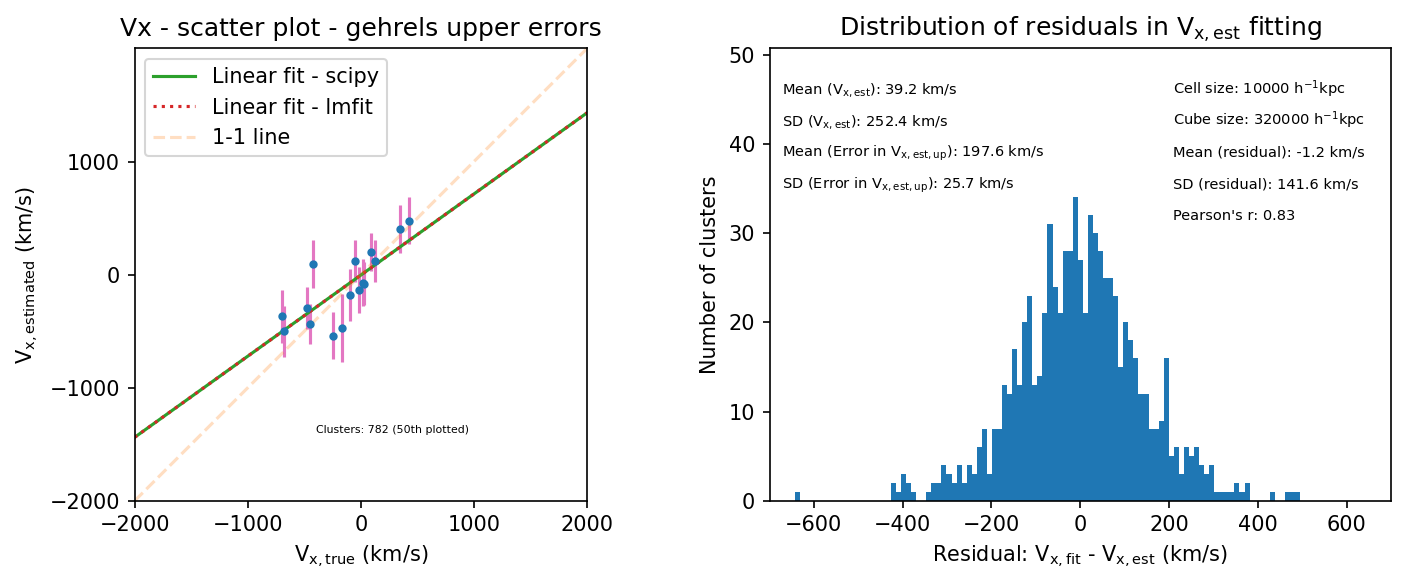

CPU times: user 1.52 s, sys: 450 ms, total: 1.97 s
Wall time: 3.35 s


In [57]:
%%time
cell_size = 10000                      #h^-1 kpc, size of pixel or cell

cube_cell_size_assess = pd.DataFrame(columns=['Cell Size', 'Act Cube Size', 'Cube Size Set', 'Clusters', 'Mean - Vx', 'Mean - Vy', 
                                              'Mean - Vz', 'SD - Vx', 'SD - Vy', 'SD - Vz', 'm - Vx', 'm - Vy', 'm - Vz', 'r - Vx', 
                                              'r - Vx_cube', 'r - Vy', 'r - Vy_cube', 'r - Vz', 'r - Vz_cube'])

cube_cell_size_assess_no_round = pd.DataFrame(columns=['Cell Size', 'Act Cube Size', 'Cube Size Set', 'Clusters', 'Mean - Vx', 'Mean - Vy', 
                                              'Mean - Vz', 'SD - Vx', 'SD - Vy', 'SD - Vz', 'm - Vx', 'm - Vy', 'm - Vz', 'r - Vx', 
                                              'r - Vx_cube', 'r - Vy', 'r - Vy_cube', 'r - Vz', 'r - Vz_cube'])
# error_type = 'sq_root'
error_type = 'gehrels_up'
# error_type = 'gehrels_low'

prop_type = 'sigma_method'
# prop_type = 'value_method'

for clus_cube_size in [320000]:
    for cell_size in [10000]:

# for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:
#     for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]:
        
        print(cell_size, clus_cube_size)
                
        no_of_cells = clus_cube_size//cell_size
        
        clus_cube_size_actual = clus_cube_size
        
        if no_of_cells % 2 != 0:
            clus_cube_size = clus_cube_size + cell_size
        
        sigma_in_pix = sigma_calc(cell_size)

        df_clusters = edge_clus_remover(clus_cube_size)
        
#         df_clusters = df_clusters.sample(n = 1, random_state = state, replace = False)

        delta_gal_mean = delta_gal_mean_func(cell_size)

        vel_terms = vel_terms_calc(cell_size, clus_cube_size)

        clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                              [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                              [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters),
                              [clus_cube_size]*len(df_clusters), [error_type]*len(df_clusters)))

        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)
        
        print('Muliprocessing complete')
        
        df_clusters_est_err = df_clusters.copy()

        df_clusters_est_err['vx_est[km/s]']     = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]']     = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]']     = [i[2] for i in v_est]
        df_clusters_est_err['vx_est_cube[km/s]']     = [i[12] for i in v_est]
        df_clusters_est_err['vy_est_cube[km/s]']     = [i[13] for i in v_est]
        df_clusters_est_err['vz_est_cube[km/s]']     = [i[14] for i in v_est]
#         df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
#         df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
#         df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
#         df_clusters_est_err['vx_est_up_err[km/s]']  = ([i[3] for i in v_est] - df_clusters_est_err['vx_est[km/s]']).abs()
#         df_clusters_est_err['vy_est_up_err[km/s]']  = ([i[4] for i in v_est] - df_clusters_est_err['vy_est[km/s]']).abs()
#         df_clusters_est_err['vz_est_up_err[km/s]']  = ([i[5] for i in v_est] - df_clusters_est_err['vz_est[km/s]']).abs()
#         df_clusters_est_err['vx_est_low_err[km/s]'] = (df_clusters_est_err['vx_est[km/s]'] - [i[6] for i in v_est]).abs()
#         df_clusters_est_err['vy_est_low_err[km/s]'] = (df_clusters_est_err['vy_est[km/s]'] - [i[7] for i in v_est]).abs()
#         df_clusters_est_err['vz_est_low_err[km/s]'] = (df_clusters_est_err['vz_est[km/s]'] - [i[8] for i in v_est]).abs()  

#         df_clusters_est_err['vx_est_up[km/s]']  = ([i[3] for i in v_est])
#         df_clusters_est_err['vy_est_up[km/s]']  = ([i[4] for i in v_est])
#         df_clusters_est_err['vz_est_up[km/s]']  = ([i[5] for i in v_est])

        if prop_type == 'value_method':    

            df_clusters_est_err['vx_est_up_err[km/s]']  = ([i[3] for i in v_est] - df_clusters_est_err['vx_est[km/s]'])
            df_clusters_est_err['vy_est_up_err[km/s]']  = ([i[4] for i in v_est] - df_clusters_est_err['vy_est[km/s]'])
            df_clusters_est_err['vz_est_up_err[km/s]']  = ([i[5] for i in v_est] - df_clusters_est_err['vz_est[km/s]'])
            
            df_clusters_est_err['vx_est_low_err[km/s]'] = (df_clusters_est_err['vx_est[km/s]'] - [i[6] for i in v_est])
            df_clusters_est_err['vy_est_low_err[km/s]'] = (df_clusters_est_err['vy_est[km/s]'] - [i[7] for i in v_est])
            df_clusters_est_err['vz_est_low_err[km/s]'] = (df_clusters_est_err['vz_est[km/s]'] - [i[8] for i in v_est]) 



        if prop_type == 'sigma_method':
            df_clusters_est_err['vx_est_up_err[km/s]'] = [i[9] for i in v_est]
            df_clusters_est_err['vy_est_up_err[km/s]'] = [i[10] for i in v_est]
            df_clusters_est_err['vz_est_up_err[km/s]'] = [i[11] for i in v_est]
            
            df_clusters_est_err['vx_est_low_err[km/s]'] = [i[9] for i in v_est]
            df_clusters_est_err['vy_est_low_err[km/s]'] = [i[10] for i in v_est]
            df_clusters_est_err['vz_est_low_err[km/s]'] = [i[11] for i in v_est] 
    
#         residuals_x, residuals_y, residuals_z, slope_x, slope_y, slope_z = plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual)
        residuals_x, slope_x = plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual, error_type)

#         cube_cell_size_assess = cube_cell_size_assess.append({'Cell Size': cell_size,
#                 'Act Cube Size': clus_cube_size_actual,
#                 'Cube Size Set': clus_cube_size,
#                 'Clusters': len(df_clusters),
#                 'Mean - Vx': round(np.mean(residuals_x),1), 
#                 'Mean - Vy': round(np.mean(residuals_y),1), 
#                 'Mean - Vz': round(np.mean(residuals_z),1), 
#                 'SD - Vx': round(np.std(residuals_x),1), 
#                 'SD - Vy': round(np.std(residuals_y),1),
#                 'SD - Vz': round(np.std(residuals_z),1), 
#                 'm - Vx': round(slope_x, 2),
#                 'm - Vy': round(slope_y, 2),
#                 'm - Vz': round(slope_z, 2),
#                 'r - Vx': round(np.corrcoef(df_clusters['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0],2),
#                 'r - Vy': round(np.corrcoef(df_clusters['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0],2),
#                 'r - Vz': round(np.corrcoef(df_clusters['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0],2)}, 
#                 ignore_index=True)
        
        cube_cell_size_assess_no_round = cube_cell_size_assess_no_round.append({'Cell Size': cell_size,
                'Act Cube Size': clus_cube_size_actual,
                'Cube Size Set': clus_cube_size,
                'Clusters': len(df_clusters),
#                 'Mean - Vx': np.mean(residuals_x), 
#                 'Mean - Vy': np.mean(residuals_y), 
#                 'Mean - Vz': np.mean(residuals_z), 
#                 'SD - Vx': np.std(residuals_x),
#                 'SD - Vy': np.std(residuals_y),
#                 'SD - Vz': np.std(residuals_z), 
                'm - Vx': slope_x,
#                 'm - Vy': slope_y,
#                 'm - Vz': slope_z,                                                                        
                'r - Vx': np.corrcoef(df_clusters['vx[km/s]'], df_clusters_est_err['vx_est[km/s]'])[1,0],
                'r - Vx_cube': np.corrcoef(df_clusters['vx[km/s]'], df_clusters_est_err['vx_est_cube[km/s]'])[1,0],
                'r - Vy': np.corrcoef(df_clusters['vy[km/s]'], df_clusters_est_err['vy_est[km/s]'])[1,0],
                'r - Vy_cube': np.corrcoef(df_clusters['vy[km/s]'], df_clusters_est_err['vy_est_cube[km/s]'])[1,0],
                'r - Vz': np.corrcoef(df_clusters['vz[km/s]'], df_clusters_est_err['vz_est[km/s]'])[1,0], 
                'r - Vz_cube': np.corrcoef(df_clusters['vz[km/s]'], df_clusters_est_err['vz_est_cube[km/s]'])[1,0]},
                ignore_index=True)
        
        clus_cube_size = clus_cube_size_actual
        

In [55]:
cube_cell_size_assess_no_round

,Cell Size,Act Cube Size,Cube Size Set,Clusters,Mean - Vx,Mean - Vy,Mean - Vz,SD - Vx,SD - Vy,SD - Vz,m - Vx,m - Vy,m - Vz,r - Vx,r - Vx_cube,r - Vy,r - Vy_cube,r - Vz,r - Vz_cube
0,10000.0,320000.0,320000.0,782.0,NaN,NaN,NaN,NaN,NaN,NaN,0.690538,NaN,NaN,0.827979,0.826863,0.809433,0.824426,0.850161,0.850046


CPU times: user 1.86 s, sys: 1.76 s, total: 3.62 s
Wall time: 5.25 s


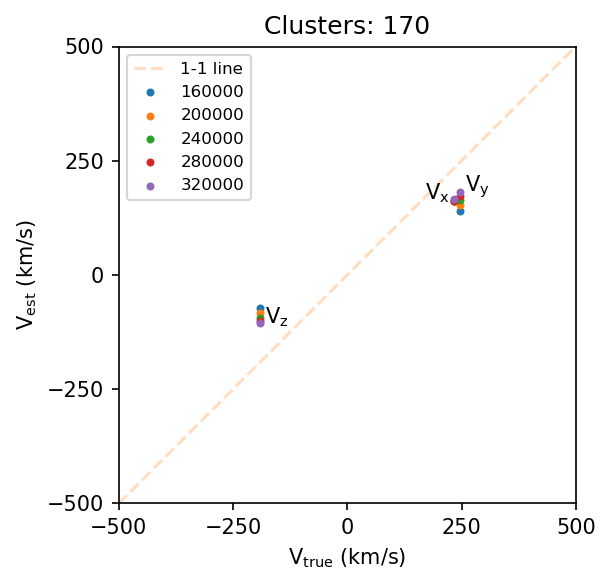

In [58]:
%%time

# error_type = 'sq_root'
# error_type = 'gehrels_up'
error_type = 'gehrels_low'

prop_type = 'sigma_method'
# prop_type = 'value_method'

# np.random.seed(0)

state = 4
df_clusters = edge_clus_remover(320000)
df_clusters = df_clusters[(df_clusters['vx[km/s]'] > 0) & 
                          (df_clusters['vy[km/s]'] > 0) & 
                          (df_clusters['vz[km/s]'] < 0) ]
# df_clusters = df_clusters.sample(n = 100, random_state = state, replace = False)
# df_clusters = df_clusters[index:index+1]

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

plt.figure(dpi = dpi, facecolor=(1, 1, 1))

for i, clus_cube_size in enumerate([160000, 200000, 240000, 280000, 320000]):
    for cell_size in [10000]:

# for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:
#     for cell_size in [10000]:
        
#         print(cell_size, clus_cube_size)
                
        no_of_cells = clus_cube_size//cell_size
        
        clus_cube_size_actual = clus_cube_size
        
        if no_of_cells % 2 != 0:
            clus_cube_size = clus_cube_size + cell_size
        
        sigma_in_pix = sigma_calc(cell_size)

#         df_clusters = edge_clus_remover(clus_cube_size)

        delta_gal_mean = delta_gal_mean_func(cell_size)

        vel_terms = vel_terms_calc(cell_size, clus_cube_size)
        
    
        clus_param = list(zip(df_clusters['x[kpc/h]'], df_clusters['y[kpc/h]'], df_clusters['z[kpc/h]'], 
                              [delta_gal_mean]*len(df_clusters), [cell_size]*len(df_clusters), 
                              [vel_terms]*len(df_clusters), [sigma_in_pix]*len(df_clusters),
                              [clus_cube_size]*len(df_clusters), [error_type]*len(df_clusters)))

        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        df_clusters_est_err = df_clusters.copy()

        df_clusters_est_err['vx_est[km/s]']     = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]']     = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]']     = [i[2] for i in v_est]
             

        
        plt.scatter(df_clusters_est_err['vx[km/s]'].mean(), df_clusters_est_err['vx_est[km/s]'].mean(), 
                    s = 8, c = colors[i],
                    label = f'{clus_cube_size}')
        
        plt.scatter(df_clusters_est_err['vy[km/s]'].mean(), df_clusters_est_err['vy_est[km/s]'].mean(), 
                    s = 8, c = colors[i])
        
        plt.scatter(df_clusters_est_err['vz[km/s]'].mean(), df_clusters_est_err['vz_est[km/s]'].mean(), 
                    s = 8, c = colors[i])
        
        clus_cube_size = clus_cube_size_actual

plt.text(df_clusters_est_err['vx[km/s]'].mean() - 10, df_clusters_est_err['vx_est[km/s]'].mean(), 'V$_\mathrm{x}$', fontsize = 10, horizontalalignment='right')         
plt.text(df_clusters_est_err['vy[km/s]'].mean() + 10, df_clusters_est_err['vy_est[km/s]'].mean(), 'V$_\mathrm{y}$', fontsize = 10)         
plt.text(df_clusters_est_err['vz[km/s]'].mean() + 10, df_clusters_est_err['vz_est[km/s]'].mean(), 'V$_\mathrm{z}$', fontsize = 10)         
        
# low_lim, high_lim = -2000, 2000
# low_lim, high_lim = -1000, 1000
# low_lim, high_lim = -800, 800
low_lim, high_lim = -500, 500
plt.xlim(low_lim, high_lim)
plt.ylim(low_lim, high_lim)
plt.gca().set_aspect('equal', adjustable='box')

plt.gca().set_xticks(range(low_lim, high_lim + 1, high_lim//2))
plt.gca().set_yticks(range(low_lim, high_lim + 1, high_lim//2))

x_range = np.arange(low_lim, high_lim+1, 5)  
plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, ls = 'dashed')

plt.xlabel('V$_\mathrm{true}$ (km/s)')
plt.ylabel('V$_\mathrm{est}$ (km/s)')

plt.legend(fontsize = 8)

# plt.title(f'State: {state} | ' + "M$_{500\mathrm{c}}$:" + " {:.2e} ".format(df_clusters['m500c[Msol/h]'].iloc[0]) + 'M$_{\odot}$h$^{-1}$');
plt.title(f'Clusters: {len(df_clusters)}')
plt.tight_layout()
# plt.savefig(f"Plots/orig-sim-box/clus_bos_size_exam/scatter_plots/State_{state}_M_500c:" + " {:.2e} ".format(df_clusters['m500c[Msol/h]'].iloc[0]) + f'M_sun h^-1.png');

In [ ]:
print('Cell size: 10 Mpc, Cube size: 240 Mpc')
df_clusters_est_err.describe()

In [ ]:
cube_cell_size_assess

**Writing & seeing the assesment table**

In [ ]:
cube_cell_size_assess_no_round.to_csv('Tables/orig-sim-box/cube_cell_size_assess_orig-sim-box_unrounded.tsv', index = False, sep = '\t')
cube_cell_size_assess.round(2).to_csv('Tables/orig-sim-box/cube_cell_size_assess_orig-sim-box_rounded.tsv', index = False, sep = '\t')
cube_cell_size_assess

**Reshaping the Pearson's r for Vz column into a more easy-to-read form**

In [ ]:
r_Vz_table = pd.DataFrame()

for name, group in cube_cell_size_assess.groupby("Cell Size"):
    if r_Vz_table.empty:
        r_Vz_table = group.set_index("Act Cube Size")[["r - Vz"]].rename(columns={"r - Vz":name})
    else:
        r_Vz_table = r_Vz_table.join(group.set_index("Act Cube Size")[["r - Vz"]].rename(columns={"r - Vz":name}))

r_Vz_table

**Plotting the mean, SD & r response due to variation of cell sizes for a given cluster cube size**

In [ ]:
x_axis = np.arange(0,6)

# for clus_cube_size in [240000]:
for clus_cube_size in [160000, 200000, 240000, 280000, 320000]:

    plt.figure(dpi = dpi, figsize = (5,9), facecolor=(1, 1, 1))
    plt.subplot(311)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Mean - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('Mean of V$_{\mathrm{est}}$ (km/s)')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    no_of_clus = int(cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['Clusters'].iloc[0])
    plt.title(r'Mean of velocity | Cube: {} h$^{}$Mpc | Clusters: {}'.format(int(clus_cube_size/1e3), minus_one, no_of_clus), fontsize = 10)

    plt.subplot(312)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['SD - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('SD of V$_{\mathrm{est}}$ (km/s)')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r'SD of velocity | Cube: {} h$^{}$Mpc | Clusters: {}'.format(int(clus_cube_size/1e3), minus_one, no_of_clus), fontsize = 10)

    plt.subplot(313)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Act Cube Size'] == clus_cube_size]['r - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cell size (h$^{-1}$kpc)')
    plt.ylabel('Pearson\'s r')
    plt.xticks(x_axis, [2000, 4000, 5000, 8000, 10000, 20000])
    minus_one = {-1}
    plt.title(r"Pearson's r | Cube: {} h$^{}$Mpc | Clusters: {}".format(int(clus_cube_size/1e3), minus_one, no_of_clus), fontsize = 10)
    plt.subplots_adjust(hspace = 0.6)
    plt.tight_layout()
    plt.savefig(f'Plots/orig-sim-box/cell_size_exam/clus_box_{clus_cube_size}.png')
    plt.close()

**Plotting the mean, SD & r response due to variation of cluster cube sizes for a given cell size**

In [ ]:

x_axis = np.arange(0,5)

# for cell_size in [5000]:
for cell_size in [2000, 4000, 5000, 8000, 10000, 20000]:

    plt.figure(dpi = dpi, figsize = (5,10), facecolor=(1, 1, 1))
    plt.subplot(311)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['Mean - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['Mean - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['Mean - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cube size (h$^{-1}$kpc)')
    plt.ylabel('Mean of V$_{\mathrm{estimated}}$ (km/s)')
    plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
    plt.ylim(0,800)
    minus_one = {-1}
    plt.title(r'Mean of velocity | Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), fontsize = 11)

    plt.subplot(312)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['SD - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cube size (h$^{-1}$kpc)')
    plt.ylabel('SD of V$_{\mathrm{estimated}}$ (km/s)')
    plt.ylim(100, 1000)
    plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
    plt.title(r'SD of velocity | Cell size: {} h$^{}$kpc'.format(cell_size, minus_one), fontsize = 11)

    plt.subplot(313)
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['r - Vx'], label = 'Vx')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['r - Vy'], label = 'Vy')
    plt.plot(x_axis, cube_cell_size_assess[cube_cell_size_assess['Cell Size'] == cell_size]['r - Vz'], label = 'Vz')
    plt.legend()
    plt.xlabel(r'Cube size (h$^{-1}$kpc)')
    plt.ylabel('Pearson\'s r')
    plt.xticks(x_axis, [160000, 200000, 240000, 280000, 320000])
    plt.ylim(0.30, 0.90)
    plt.title(r"Pearson's r | Cell size: {} h$^{}$kpc".format(cell_size, minus_one), fontsize = 11)

    plt.subplots_adjust(hspace = 0.7)
    plt.tight_layout()
    plt.savefig(f'Plots/orig-sim-box/clus_bos_size_exam/cell_size_{cell_size}.png')
#     plt.savefig(f'Plots/orig-sim-box/clus_bos_size_exam/free_y_lim/cell_size_{cell_size}.png')
    plt.close()

**Finding the minimum value of mean & Sd, and maximum value of r**

In [ ]:
print(cube_cell_size_assess['Mean - Vx'].abs().min())
print(cube_cell_size_assess['Mean - Vy'].abs().min())
print(cube_cell_size_assess['Mean - Vz'].abs().min())
print(cube_cell_size_assess['SD - Vx'].abs().min())
print(cube_cell_size_assess['SD - Vy'].abs().min())
print(cube_cell_size_assess['SD - Vz'].abs().min())
print(cube_cell_size_assess['r - Vx'].max())
print(cube_cell_size_assess['r - Vy'].max())
print(cube_cell_size_assess['r - Vz'].max())

**Conclusions**
1. All three components of velocities behave similarly so anyone of them can be taken from now onwards as the line of sight velocity. Pearson's r is highest (0.85) for V$_\mathrm{z}$ so maybe prefer V$_\mathrm{z}$ .
2. The code to estimate velocity seems to work fine since:  
(a) mean error in V$_\mathrm{x}$ goes to 0.3 km/s for cell size of 10,000 h$^\mathrm{-1}$kpc & cluster box size of 160,000 h$^\mathrm{-1}$kpc (SD is 185 km/s & r is 	0.78 for this case)   
(b) standard deviation of error in V$_\mathrm{z}$ goes to 146 km/s for cell size of 10,000 h$^\mathrm{-1}$kpc & cluster box size of 320,000 h$^\mathrm{-1}$kpc (Mean is -41.7 km/s & r is 0.85 for this case)  
(c) Pearson's r goes to 0.85 for V$_\mathrm{z}$ estimates coming from cell size of 10,000 h$^\mathrm{-1}$kpc & cluster box size of 280,000 h$^\mathrm{-1}$kpc (Mean is -43 km/s & SD is 152 km/s for this case)
3. Cell size of 10,000 h$^\mathrm{-1}$kpc should be chosen since it gives least mean, SD & maximum r.
4. Cluster box size does not make much difference but higher values do give a litter better mean, SD and r. A value of 280,000 h$^\mathrm{-1}$kpc may be choszen since it give r of 0.85.